Neural Network Embedding-based Collaborative Filtering model

In [35]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds = []
all_actuals = []


In [37]:
# 1. Load data
df = pd.read_csv("course_ratings.csv")

In [38]:
#2. Encode users and items to indices
user_ids = df['user'].unique()
item_ids = df['item'].unique()
user2idx = {user: idx for idx, user in enumerate(user_ids)}
item2idx = {item: idx for idx, item in enumerate(item_ids)}

df['user'] = df['user'].map(user2idx)
df['item'] = df['item'].map(item2idx)

In [39]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [40]:
# 4. PyTorch Dataset class
class RatingDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe['user'].values, dtype=torch.long)
        self.items = torch.tensor(dataframe['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(dataframe['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_ds = RatingDataset(train_df)
test_ds = RatingDataset(test_df)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

# 5. Neural Network Model
class RecommenderNet(nn.Module):
    def __init__(self, n_users, n_items, embed_dim=50):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embed_dim)
        self.item_embedding = nn.Embedding(n_items, embed_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        user_vec = self.user_embedding(user)
        item_vec = self.item_embedding(item)
        x = torch.cat([user_vec, item_vec], dim=1)
        return self.fc_layers(x).squeeze()


In [41]:
# 6. Model setup
n_users = len(user2idx)
n_items = len(item2idx)

model = RecommenderNet(n_users, n_items).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [42]:
# 7. Training loop (with loss history tracking)
epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for user, item, rating in train_dl:
        user, item, rating = user.to(device), item.to(device), rating.to(device)
        pred = model(user, item)
        loss = loss_fn(pred, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}")


Epoch 1/5, Training Loss: 0.8708
Epoch 2/5, Training Loss: 0.6883
Epoch 3/5, Training Loss: 0.6736
Epoch 4/5, Training Loss: 0.6659
Epoch 5/5, Training Loss: 0.6552


In [43]:
# 8. Evaluation
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for user, item, rating in test_dl:
        user, item = user.to(device), item.to(device)
        preds = model(user, item).cpu().numpy()
        all_preds.extend(preds)
        all_actuals.extend(rating.numpy())

rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.8277


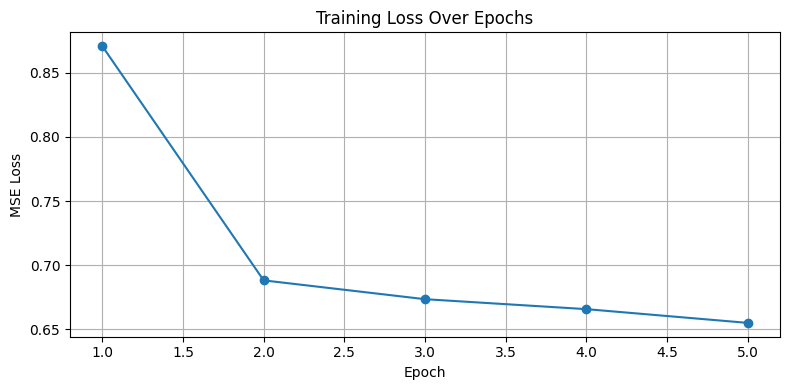

In [44]:
import matplotlib.pyplot as plt

# Training Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

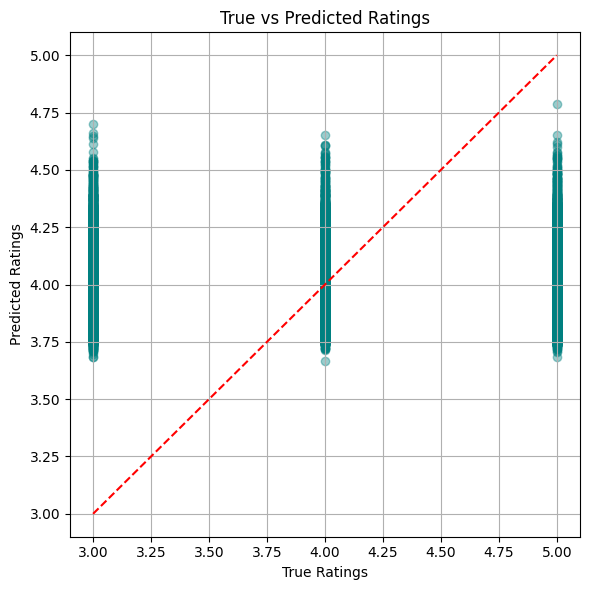

In [45]:
# Scatter Plot: True vs Predicted Ratings
plt.figure(figsize=(6, 6))
plt.scatter(all_actuals, all_preds, alpha=0.4, color='teal')
plt.plot([min(all_actuals), max(all_actuals)],
         [min(all_actuals), max(all_actuals)], 'r--')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.grid(True)
plt.tight_layout()
plt.show()

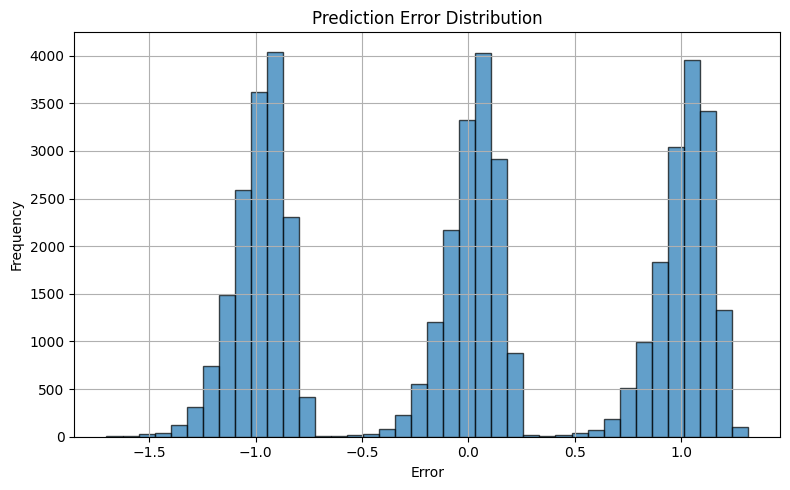

In [46]:
# Error Distribution
errors = np.array(all_actuals) - np.array(all_preds)
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=40, edgecolor='black', alpha=0.7)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()